# 274to289 (1-15 Oktober)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Oct1-15woP deaths.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_leth_AGS_274to289']
X = df.loc[:, ~df.columns.isin(['std_leth_AGS_274to289'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  147


# Feature Correlation

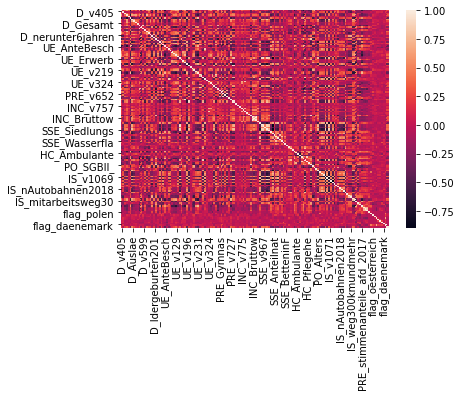

In [4]:
corr = X.corr()
sns.heatmap(corr)

In [5]:
pairs = []

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.8:
            pairs.append(corr.columns[[i,j]][0])
            pairs.append(corr.columns[[i,j]][1])
            print(corr.columns[[i,j]],corr.iloc[i,j])
            

Index(['D_Lebens', 'D_v599'], dtype='object') 0.9204456724863153
Index(['D_Lebens', 'HC_Vorzeitig'], dtype='object') -0.853570725481162
Index(['UE_ArbquoteJ', 'PO_SGBII_'], dtype='object') 0.8310490758054104
Index(['UE_AntreBesc', 'UE_AnteBesch'], dtype='object') -0.8073819685836338
Index(['UE_BesePrima', 'UE_v305'], dtype='object') 0.8333318048923829
Index(['UE_Erwerb', 'SSE_Einwohner'], dtype='object') 0.8980642650031009
Index(['UE_Erwerb', 'SSE_v967'], dtype='object') 0.9540188242864167
Index(['UE_Erwerb', 'SSE_Siedlungs'], dtype='object') 0.8849779610806378
Index(['UE_Erwerb', 'SSE_AnteilErh'], dtype='object') 0.8137246324046928
Index(['UE_Erwerb', 'SSE_AnteilFre'], dtype='object') -0.897382514680414
Index(['UE_v190', 'PRE_v727'], dtype='object') 0.9155820449459644
Index(['UE_v202', 'PRE_v733'], dtype='object') 0.930634945720119
Index(['UE_v202', 'PRE_v739'], dtype='object') 0.8741009848581435
Index(['UE_v251', 'UE_v381'], dtype='object') 0.86208012245028
Index(['UE_Dienst', 'HC_ae

In [6]:
len(pairs)
len(set(pairs))

44

In [ ]:
#sns.heatmap(X[set(pairs)].corr())

# First CatBoost Model with 147 features

In [7]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9990081839699005


In [8]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  0.027912220294388727


# SHAP VAlues

In [9]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

invalid value encountered in true_divide
invalid value encountered in true_divide


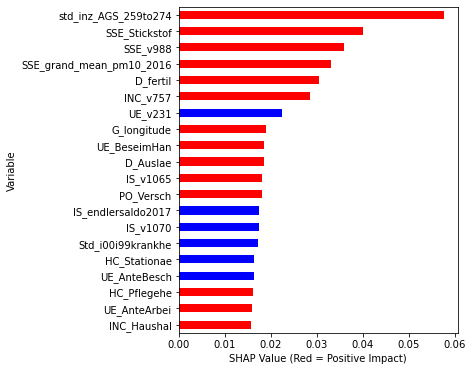

In [10]:
def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

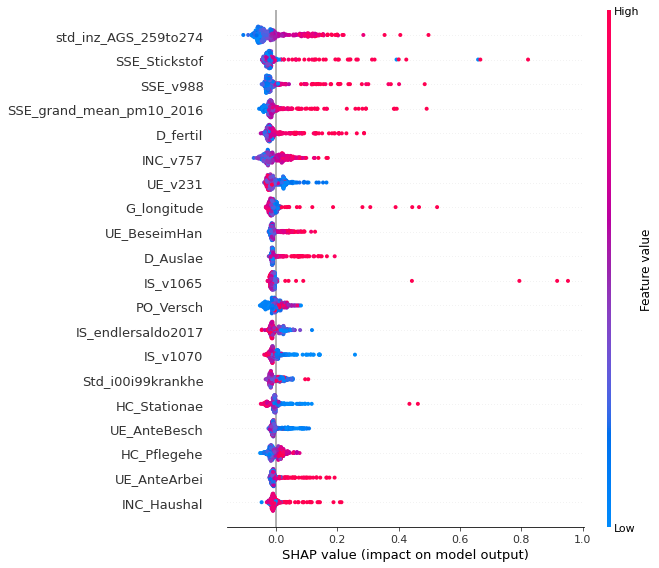

In [11]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [12]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [13]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9954535482447359


In [14]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  0.059760622945420276


# Compare top 10 features of both Models

In [15]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_259to274', 'SSE_Stickstof', 'SSE_v988', 'SSE_grand_mean_pm10_2016', 'D_fertil', 'INC_v757', 'UE_v231', 'G_longitude', 'UE_BeseimHan', 'D_Auslae'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_259to274', 'INC_v757', 'SSE_v988', 'D_fertil', 'Std_i00i99krankhe', 'SSE_grand_mean_pm10_2016', 'SSE_Stickstof', 'UE_AnteArbei', 'PO_Versch', 'D_Auslae']


In [16]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_259to274
SSE_Stickstof
SSE_v988
SSE_grand_mean_pm10_2016
D_fertil
INC_v757
D_Auslae


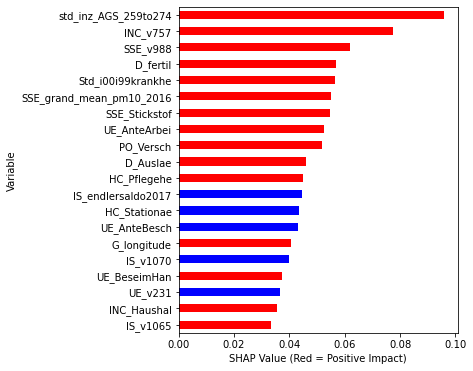

In [17]:
ABS_SHAP(shap_values_cb_20,X[top20feature]) 

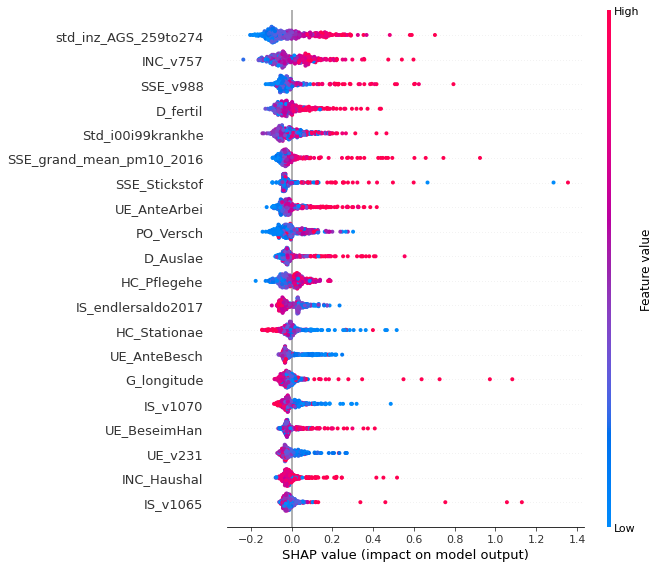

In [18]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [19]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [20]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9971274337398344
Mean R2 of linReg_modesl with top20 features:  0.1721895398163125
Mean RMSE of CatBoost_models on test sets with top20 features:  0.7926796275280663
Mean R2 of CatBoost_models on test sets with top20 features: 0.1464023520099445


# descriptives of top20 features

In [21]:
X[top20feature].describe()

,std_inz_AGS_259to274,SSE_Stickstof,SSE_v988,SSE_grand_mean_pm10_2016,D_fertil,INC_v757,UE_v231,G_longitude,UE_BeseimHan,D_Auslae,IS_v1065,PO_Versch,IS_endlersaldo2017,IS_v1070,Std_i00i99krankhe,HC_Stationae,UE_AnteBesch,HC_Pflegehe,UE_AnteArbei,INC_Haushal
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,26.810415,68.331635,33367.324219,14.254108,1.632220,8.945634,15.151626,9.866997,13.988775,10.034916,21.925186,1682.694702,-10.362344,1418.311768,350.949554,24.358616,20.186029,97.709465,22.971321,1591.685791
std,19.821966,27.160891,30681.789062,2.204698,0.134031,2.964478,3.232546,2.026269,4.891642,5.149191,15.378860,1549.749634,29.724245,808.548523,70.654755,5.373880,2.235633,23.278893,4.190942,589.468811
min,0.000000,21.400000,1062.000000,8.902052,1.060000,-14.300000,9.000000,6.083333,0.000000,1.900000,0.000000,0.000000,-149.399994,101.000000,0.000000,11.100000,14.800000,40.700001,14.500000,2.000000
25%,13.653437,47.500000,15678.000000,12.644478,1.560000,7.700000,13.100000,8.216666,10.600000,6.200000,13.000000,649.700012,-25.299999,682.000000,314.081635,20.400000,18.600000,80.400002,19.500000,1591.000000
50%,22.629042,59.200001,24587.000000,14.194455,1.650000,9.000000,14.500000,9.766666,13.900000,9.200000,21.000000,1167.900024,-12.000000,1388.000000,348.257904,23.700001,19.900000,96.800003,22.700001,1764.000000
75%,36.430935,88.199997,39522.000000,15.811378,1.720000,10.700000,16.100000,11.416667,16.900000,13.100000,32.000000,2247.600098,4.800000,2019.000000,393.922150,27.500000,21.299999,113.900002,25.900000,1904.000000
max,173.247955,150.699997,174293.000000,21.132412,1.940000,24.700001,28.200001,14.983334,47.700001,35.000000,79.000000,9908.299805,62.700001,3819.000000,538.368652,43.299999,27.400000,184.899994,34.700001,2904.000000


In [22]:
pd.DataFrame(Y).describe()

,std_leth_AGS_274to289
count,401.000000
mean,0.500069
std,0.887404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.735075
max,4.681872


In [ ]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives1.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 1')